In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import suppression as s
import utils

In [4]:
gaba_fn = 'gaba_data.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [5]:
sdf = utils.load_psychophys(supp_fn)
gdf = utils.load_gaba(gaba_fn)

In [6]:
np.unique(sdf.Subject)

array(['ah', 'ai', 'am', 'ap', 'bi', 'bo', 'cl', 'cr', 'ct', 'dl', 'ds',
       'eg', 'ei', 'em', 'es', 'gd', 'gm', 'gw', 'jd', 'jv', 'ke', 'kw',
       'li', 'ls', 'mg', 'mk', 'ms', 'mv', 'nl', 'nn', 'rn', 'sd', 'se',
       'tj', 'tm', 'tt', 'yl'], dtype=object)

In [7]:
gdf.head()

,subjName,Population,Presentation,GABA
0,ac,Amblyope,occ_binoc,0.196
2,am,Amblyope,occ_binoc,0.193
4,as,Amblyope,occ_binoc,0.217
6,bi,Amblyope,occ_binoc,0.207
8,ch,Amblyope,occ_binoc,0.191


## Identify common subjects, subset data frames to only include these ##

In [8]:
pp_subjs = np.unique(sdf.Subject)
gaba_subjs = np.unique(gdf.subjName)
use_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
print(pp_subjs, len(pp_subjs))
print(gaba_subjs, len(gaba_subjs))
print(use_subjs, len(use_subjs))

['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em' 'es'
 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv' 'nl' 'nn'
 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl'] 37
['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm'
 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn' 'sd' 'tt'
 'yl'] 31
['ai', 'am', 'bi', 'cr', 'ct', 'dl', 'ei', 'em', 'es', 'gd', 'gm', 'jd', 'jv', 'kw', 'li', 'ls', 'mg', 'mk', 'ms', 'nl', 'rn', 'sd', 'tt', 'yl'] 24


In [9]:
gdf = gdf[gdf.subjName.isin(use_subjs)] # only subjects who did both tasks
gdf = gdf[gdf.Presentation=='occ_binoc'] # use this GABA measure
gdf

,subjName,Population,Presentation,GABA
2,am,Amblyope,occ_binoc,0.193
6,bi,Amblyope,occ_binoc,0.207
12,em,Amblyope,occ_binoc,0.182
14,gd,Amblyope,occ_binoc,0.203
16,jv,Amblyope,occ_binoc,0.215
20,li,Amblyope,occ_binoc,0.227
22,mg,Amblyope,occ_binoc,0.210
26,rn,Amblyope,occ_binoc,0.202
28,sd,Amblyope,occ_binoc,0.190
30,tt,Amblyope,occ_binoc,0.179


In [10]:
len(gdf[gdf['Population']=='Amblyope'])

10

In [11]:
len(gdf)

24

In [12]:
sdf = sdf[sdf.Subject.isin(use_subjs)] # only subjects who did both tasks
# make sure there are only as many unique subjNames in sdf as there are entries in gdf.subjName
assert(len(np.unique(sdf.Subject))==len(gdf.subjName))

## Pick which task to analyze

In [17]:
sdf = sdf[sdf['Task']=='SS']

## Model Psychophysical data ##
### ThreshElev as a function of logRelContrast ###

In [18]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace']
pp_gvars_base = pp_gvars + ['BaselineThresh']

In [19]:
print(pp_gvars, '\n', pp_gvars_base)

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace'] 
 ['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [20]:
# create groups based on these grouping variables
groups = sdf.groupby(pp_gvars)
print(len(groups))
for g in groups:
    print(g)

184
(('SS', 'Cross', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De'),     Subject Task Presentation Orientation Eye Population  MaskContrast  \
923      am   SS       nDicho       Cross  De   Amblyope          10.0   
924      am   SS       nDicho       Cross  De   Amblyope          18.0   
925      am   SS       nDicho       Cross  De   Amblyope          32.0   
926      am   SS       nDicho       Cross  De   Amblyope          56.0   
927      am   SS       nDicho       Cross  De   Amblyope          74.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
923       0.505          0.008            1.276  Amblyope-De           7.532   
924       0.553          0.009            2.298  Amblyope-De           7.532   
925       0.416          0.013            4.085  Amblyope-De           7.532   
926       0.485          0.007            7.148  Amblyope-De           7.532   
927       0.611          0.008            9.446  Amblyope-De           7.532   

   

952                    16.851          8       0.102777            1.219611  )
(('SS', 'Cross', 'nDicho', 'Amblyope', 'jv', 'Nde', 'Amblyope-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
845      jv   SS       nDicho       Cross  Nde   Amblyope          39.0   
846      jv   SS       nDicho       Cross  Nde   Amblyope          50.0   
847      jv   SS       nDicho       Cross  Nde   Amblyope          79.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast         Trace  BaselineThresh  \
845       1.419          0.007            9.225  Amblyope-Nde           4.764   
846       1.277          0.007           11.828  Amblyope-Nde           4.764   
847       2.503          0.007           18.687  Amblyope-Nde           4.764   

     BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
845                    10.949          6       0.151982            0.964966  
846                    10.949          6       0.106191            1.0

(('SS', 'Cross', 'nDicho', 'Amblyope', 'sd', 'Nde', 'Amblyope-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
862      sd   SS       nDicho       Cross  Nde   Amblyope          18.0   
863      sd   SS       nDicho       Cross  Nde   Amblyope          32.0   
864      sd   SS       nDicho       Cross  Nde   Amblyope          45.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast         Trace  BaselineThresh  \
862       1.140          0.011            2.874  Amblyope-Nde          13.226   
863       1.337          0.011            5.110  Amblyope-Nde          13.226   
864       1.708          0.010            7.186  Amblyope-Nde          13.226   

     BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
862                     2.604          3       0.056905            0.458487  
863                     4.526          4       0.126131            0.708421  
864                     7.257          5       0.232488            0.85

878                     6.517          5       0.173186            0.891872  )
(('SS', 'Cross', 'nDicho', 'Control', 'dl', 'Nde', 'Control-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
752      dl   SS       nDicho       Cross  Nde    Control           5.0   
753      dl   SS       nDicho       Cross  Nde    Control          10.0   
754      dl   SS       nDicho       Cross  Nde    Control          18.0   
755      dl   SS       nDicho       Cross  Nde    Control          32.0   
756      dl   SS       nDicho       Cross  Nde    Control          45.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
752       1.762          0.007            0.741  Control-Nde           5.772   
753       1.204          0.014            1.483  Control-Nde           5.772   
754       1.740          0.007            2.669  Control-Nde           5.772   
755       1.469          0.009            4.744  Control-Nde           5.772   
756

894                    11.877          6       0.088845            1.059563  )
(('SS', 'Cross', 'nDicho', 'Control', 'jd', 'Nde', 'Control-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
774      jd   SS       nDicho       Cross  Nde    Control          10.0   
775      jd   SS       nDicho       Cross  Nde    Control          30.0   
776      jd   SS       nDicho       Cross  Nde    Control          62.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
774       0.811          0.008            1.793  Control-Nde           5.405   
775       1.108          0.010            5.380  Control-Nde           5.405   
776       1.912          0.011           11.119  Control-Nde           5.405   

     BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
774                     1.562          2      -0.090979            0.253580  
775                     6.610          5       0.044540            0.730782 

451                     7.235          5       0.083144            0.805433  )
(('SS', 'Cross', 'nMono', 'Amblyope', 'bi', 'Nde', 'Amblyope-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
343      bi   SS        nMono       Cross  Nde   Amblyope          10.0   
344      bi   SS        nMono       Cross  Nde   Amblyope          30.0   
345      bi   SS        nMono       Cross  Nde   Amblyope          50.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast         Trace  BaselineThresh  \
343       1.000          0.009            0.986  Amblyope-Nde          10.141   
344       1.070          0.010            2.958  Amblyope-Nde          10.141   
345       1.265          0.009            4.931  Amblyope-Nde          10.141   

     BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
343                     0.878          2       0.000000           -0.006123  
344                     2.500          4       0.029384            0.47

478                    11.982          6       0.218536            1.090152  )
(('SS', 'Cross', 'nMono', 'Amblyope', 'li', 'Nde', 'Amblyope-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
367      li   SS        nMono       Cross  Nde   Amblyope           5.0   
368      li   SS        nMono       Cross  Nde   Amblyope          10.0   
369      li   SS        nMono       Cross  Nde   Amblyope          18.0   
370      li   SS        nMono       Cross  Nde   Amblyope          32.0   
371      li   SS        nMono       Cross  Nde   Amblyope          50.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast         Trace  BaselineThresh  \
367       0.894          0.008            0.683  Amblyope-Nde           7.316   
368       0.858          0.012            1.367  Amblyope-Nde           7.316   
369       0.777          0.009            2.460  Amblyope-Nde           7.316   
370       0.910          0.007            4.374  Amblyope-Nde           7.316 

(('SS', 'Cross', 'nMono', 'Control', 'dl', 'Nde', 'Control-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
266      dl   SS        nMono       Cross  Nde    Control           5.0   
267      dl   SS        nMono       Cross  Nde    Control          10.0   
268      dl   SS        nMono       Cross  Nde    Control          18.0   
269      dl   SS        nMono       Cross  Nde    Control          32.0   
270      dl   SS        nMono       Cross  Nde    Control          45.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
266       1.251          0.008            0.866  Control-Nde           5.772   
267       0.998          0.008            1.732  Control-Nde           5.772   
268       0.867          0.006            3.118  Control-Nde           5.772   
269       1.158          0.007            5.544  Control-Nde           5.772   
270       1.415          0.008            7.796  Control-Nde           5.772   

  

(('SS', 'Cross', 'nMono', 'Control', 'kw', 'Nde', 'Control-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
299      kw   SS        nMono       Cross  Nde    Control          10.0   
300      kw   SS        nMono       Cross  Nde    Control          30.0   
301      kw   SS        nMono       Cross  Nde    Control          79.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
299       0.985          0.005            1.890  Control-Nde           5.292   
300       1.218          0.006            5.669  Control-Nde           5.292   
301       1.383          0.006           14.928  Control-Nde           5.292   

     BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
299                     1.552          2      -0.006564            0.276462  
300                     6.492          5       0.085647            0.753506  
301                    11.400          6       0.140822            1.174002  )

(('SS', 'Cross', 'nMono', 'Control', 'yl', 'Nde', 'Control-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
331      yl   SS        nMono       Cross  Nde    Control          10.0   
332      yl   SS        nMono       Cross  Nde    Control          30.0   
333      yl   SS        nMono       Cross  Nde    Control          99.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
331       0.753          0.007            2.111  Control-Nde           4.738   
332       0.935          0.007            6.332  Control-Nde           4.738   
333       1.346          0.007           20.896  Control-Nde           4.738   

     BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
331                     2.446          3      -0.123205            0.324488  
332                     6.492          5      -0.029188            0.801541  
333                    18.896          7       0.129045            1.320063  )

(('SS', 'Iso', 'nDicho', 'Amblyope', 'li', 'Nde', 'Amblyope-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
610      li   SS       nDicho         Iso  Nde   Amblyope           5.0   
611      li   SS       nDicho         Iso  Nde   Amblyope          10.0   
612      li   SS       nDicho         Iso  Nde   Amblyope          18.0   
613      li   SS       nDicho         Iso  Nde   Amblyope          32.0   
614      li   SS       nDicho         Iso  Nde   Amblyope          50.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast         Trace  BaselineThresh  \
610       0.790          0.007            1.231  Amblyope-Nde           7.316   
611       0.641          0.020            2.461  Amblyope-Nde           7.316   
612       0.908          0.009            4.431  Amblyope-Nde           7.316   
613       0.738          0.010            7.877  Amblyope-Nde           7.316   
614       3.812          0.007           12.307  Amblyope-Nde           7.316

(('SS', 'Iso', 'nDicho', 'Control', 'cr', 'Nde', 'Control-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
507      cr   SS       nDicho         Iso  Nde    Control          10.0   
508      cr   SS       nDicho         Iso  Nde    Control          30.0   
509      cr   SS       nDicho         Iso  Nde    Control          79.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
507       1.515          0.006            2.479  Control-Nde           3.124   
508       1.413          0.008            7.438  Control-Nde           3.124   
509       5.173          0.006           19.586  Control-Nde           3.124   

     BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
507                     2.438          3       0.180413            0.394277  
508                     6.545          5       0.150142            0.871456  
509                    18.988          7       0.713742            1.291946  )


659                    11.877          6       0.366610            1.174002  )
(('SS', 'Iso', 'nDicho', 'Control', 'kw', 'Nde', 'Control-Nde'),     Subject Task Presentation Orientation  Eye Population  MaskContrast  \
544      kw   SS       nDicho         Iso  Nde    Control          10.0   
545      kw   SS       nDicho         Iso  Nde    Control          30.0   
546      kw   SS       nDicho         Iso  Nde    Control          79.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
544       0.833          0.008            1.785  Control-Nde           5.292   
545       1.196          0.009            5.356  Control-Nde           5.292   
546       2.897          0.006           14.105  Control-Nde           5.292   

     BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
544                     1.583          2      -0.079355            0.251638  
545                     6.545          5       0.077731            0.728841  


(('SS', 'Iso', 'nMono', 'Amblyope', 'em', 'De', 'Amblyope-De'),     Subject Task Presentation Orientation Eye Population  MaskContrast  \
215      em   SS        nMono         Iso  De   Amblyope           5.0   
216      em   SS        nMono         Iso  De   Amblyope          10.0   
217      em   SS        nMono         Iso  De   Amblyope          17.0   
218      em   SS        nMono         Iso  De   Amblyope          99.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
215       0.538          0.009            0.841  Amblyope-De           5.949   
216       0.628          0.005            1.681  Amblyope-De           5.949   
217       0.736          0.007            2.858  Amblyope-De           5.949   
218       1.022          0.017           16.642  Amblyope-De           5.949   

     BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
215                     0.792          1      -0.269218           -0.075204  
216     

(('SS', 'Iso', 'nMono', 'Amblyope', 'rn', 'De', 'Amblyope-De'),     Subject Task Presentation Orientation Eye Population  MaskContrast  \
239      rn   SS        nMono         Iso  De   Amblyope           5.0   
240      rn   SS        nMono         Iso  De   Amblyope          10.0   
241      rn   SS        nMono         Iso  De   Amblyope          18.0   

     ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
239       0.619          0.011            0.778  Amblyope-De           6.424   
240       0.686          0.008            1.557  Amblyope-De           6.424   
241       1.140          0.008            2.802  Amblyope-De           6.424   

     BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
239                     0.792          1      -0.208309           -0.109020  
240                     1.463          2      -0.163676            0.192289  
241                     2.637          3       0.056905            0.447468  )
(('SS

(('SS', 'Iso', 'nMono', 'Control', 'ct', 'Nde', 'Control-Nde'),    Subject Task Presentation Orientation  Eye Population  MaskContrast  \
17      ct   SS        nMono         Iso  Nde    Control          10.0   
18      ct   SS        nMono         Iso  Nde    Control          30.0   
19      ct   SS        nMono         Iso  Nde    Control          62.0   

    ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
17       0.620          0.007            1.137  Control-Nde           8.794   
18       1.179          0.006            3.411  Control-Nde           8.794   
19       2.268          0.007            7.050  Control-Nde           8.794   

    BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
17                     0.960          1      -0.207608            0.055760  
18                     3.944          4       0.071514            0.532882  
19                     6.405          5       0.355643            0.848189  )
(('SS', 'Iso'

(('SS', 'Iso', 'nMono', 'Control', 'jd', 'Nde', 'Control-Nde'),    Subject Task Presentation Orientation  Eye Population  MaskContrast  \
43      jd   SS        nMono         Iso  Nde    Control          10.0   
44      jd   SS        nMono         Iso  Nde    Control          30.0   
45      jd   SS        nMono         Iso  Nde    Control          62.0   

    ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
43       0.836          0.008             1.85  Control-Nde           5.405   
44       1.386          0.007             5.55  Control-Nde           5.405   
45       3.585          0.008            11.47  Control-Nde           5.405   

    BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
43                     1.552          2      -0.077794            0.267172  
44                     6.405          5       0.141763            0.744293  
45                    11.345          6       0.554489            1.059563  )
(('SS', 'Iso'

192                    19.644          7       0.475235            1.273626  )
(('SS', 'Iso', 'nMono', 'Control', 'yl', 'Nde', 'Control-Nde'),    Subject Task Presentation Orientation  Eye Population  MaskContrast  \
82      yl   SS        nMono         Iso  Nde    Control          10.0   
83      yl   SS        nMono         Iso  Nde    Control          30.0   
84      yl   SS        nMono         Iso  Nde    Control          99.0   

    ThreshElev  ThreshElev_SE  RelMaskContrast        Trace  BaselineThresh  \
82       0.637          0.010            2.111  Control-Nde           4.738   
83       1.557          0.007            6.332  Control-Nde           4.738   
84       3.609          0.011           20.896  Control-Nde           4.738   

    BinCenterRelMaskContrast  BinNumber  logThreshElev  logRelMaskContrast  
82                     2.446          3      -0.195861            0.324488  
83                     6.405          5       0.192289            0.801541  
84          

### Do t-tests between corresponding points (to find where the lines are most different)

In [21]:
tt_df = sdf

In [22]:
tt_df.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566
14,cr,SS,nMono,Iso,Nde,Control,10.0,0.906,0.006,3.201,Control-Nde,3.124,3.944,4,-0.042872,0.505286
15,cr,SS,nMono,Iso,Nde,Control,30.0,2.218,0.005,9.604,Control-Nde,3.124,11.345,6,0.345962,0.982452


In [23]:
gvars_ttest = ['Task','Orientation','Presentation','Population']
gvars_pair = gvars_ttest + ['BinNumber']

tt_grouped = tt_df.groupby(gvars_ttest)
print(len(tt_grouped))

for gv, g in tt_grouped:
    print(gv)

8
('SS', 'Cross', 'nDicho', 'Amblyope')
('SS', 'Cross', 'nDicho', 'Control')
('SS', 'Cross', 'nMono', 'Amblyope')
('SS', 'Cross', 'nMono', 'Control')
('SS', 'Iso', 'nDicho', 'Amblyope')
('SS', 'Iso', 'nDicho', 'Control')
('SS', 'Iso', 'nMono', 'Amblyope')
('SS', 'Iso', 'nMono', 'Control')


In [24]:
def tt(ttg_allbin):
    '''Accepts data grouped by Task, Orientation, Presentation, Population, then analyzes each bin within this.'''
    g_bin = ttg_allbin.groupby(gvars_pair).apply(tt_onebin).reset_index()
    minp_bin = g_bin.BinNumber.iat[g_bin.pvalue.idxmin()]
    print('Bin ', minp_bin, 'has lowest p-value.\n')
    return pd.Series(minp_bin, ['BinNumberToPred'])

def tt_onebin(ttg):
    '''Accepts data grouped by Task, Orientation, Presentation, Population, BinNumber, and does a t-test on the values in the bin.'''
    nde = ttg[ttg['Eye']=='Nde']['ThreshElev'].values
    de = ttg[ttg['Eye']=='De']['ThreshElev'].values
    print(ttg.name, ttg.BinCenterRelMaskContrast.iat[0], nde, de, sep='\n')
    if (len(nde) >0 and len(de) >0):
        tt_res = st.ttest_ind(nde, de)
        if tt_res:
            return pd.Series(tt_res[1], ['pvalue'])
    else:
        print('A group with no obs, skipping')

tt_results = tt_grouped.apply(tt).reset_index()

('SS', 'Cross', 'nDicho', 'Amblyope', 1)
0.792
[ 1.434  0.805  1.043]
[ 1.026  0.807]
('SS', 'Cross', 'nDicho', 'Amblyope', 1)
0.792
[ 1.434  0.805  1.043]
[ 1.026  0.807]
('SS', 'Cross', 'nDicho', 'Amblyope', 2)
1.432
[ 1.056  1.057  1.755  0.888  1.296  1.076]
[ 0.859  0.542  0.98   0.642]
('SS', 'Cross', 'nDicho', 'Amblyope', 3)
2.604
[ 1.378  3.318  1.007  1.459  0.68   1.555  1.14 ]
[ 0.505  0.759  0.964  0.867  1.099  0.718]
('SS', 'Cross', 'nDicho', 'Amblyope', 4)
4.526
[ 1.275  1.585  1.195  1.369  1.337]
[ 0.553  0.935  0.617  1.125  1.17   0.76   0.591  0.685]
('SS', 'Cross', 'nDicho', 'Amblyope', 5)
7.257
[ 1.677  2.306  1.49   2.387  0.82   1.708]
[ 0.416  0.918  1.     1.05   1.022]
('SS', 'Cross', 'nDicho', 'Amblyope', 6)
10.949
[ 1.79   1.419  1.277  4.002]
[ 0.485  0.945  1.534  1.253]
('SS', 'Cross', 'nDicho', 'Amblyope', 7)
21.202
[ 2.503  1.273]
[ 0.611  1.334  1.638]
('SS', 'Cross', 'nDicho', 'Amblyope', 8)
16.851
[]
[ 0.794  1.267  1.144]
A group with no obs, skipp

In [25]:
tt_results

,Task,Orientation,Presentation,Population,BinNumberToPred
0,SS,Cross,nDicho,Amblyope,4
1,SS,Cross,nDicho,Control,1
2,SS,Cross,nMono,Amblyope,2
3,SS,Cross,nMono,Control,1
4,SS,Iso,nDicho,Amblyope,4
5,SS,Iso,nDicho,Control,6
6,SS,Iso,nMono,Amblyope,5
7,SS,Iso,nMono,Control,2


In [26]:
sdf = pd.merge(sdf, tt_results, on=gvars_ttest)

In [27]:
sdf.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast,BinNumberToPred
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068,2
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290,2
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566,2
3,cr,SS,nMono,Iso,Nde,Control,10.0,0.906,0.006,3.201,Control-Nde,3.124,3.944,4,-0.042872,0.505286,2
4,cr,SS,nMono,Iso,Nde,Control,30.0,2.218,0.005,9.604,Control-Nde,3.124,11.345,6,0.345962,0.982452,2


In [28]:
# make sure all conditions have the same bin number to predict within them
condition_groups = sdf.groupby(gvars_ttest + ['Eye'])
assert(np.all(condition_groups.apply(
        lambda g: np.all(g.BinNumberToPred==g.BinNumberToPred.iat[0])
    ).reset_index()))

In [29]:
gvars_ttest

['Task', 'Orientation', 'Presentation', 'Population']

In [30]:
# add col with numeric value at which we want model to be evaluated
# this is determined per condition so reuse var
def add_pred_col(g):
    assert(np.all(g.BinNumberToPred==g.BinNumberToPred.iat[0]))
    RelMCToPredGroup = g[g.BinNumber==g.BinNumberToPred.iat[0]]
    assert(np.all(RelMCToPredGroup.BinCenterRelMaskContrast==RelMCToPredGroup.BinCenterRelMaskContrast.iat[0]))
    RelMCToPred = RelMCToPredGroup.BinCenterRelMaskContrast.iat[0]
    print(RelMCToPred, len(g))
    g['RelMCToPred'] = RelMCToPred
    return g
    
df_to_model = condition_groups.apply(add_pred_col)

2.5 35
2.5 35
4.526 33
0.879 48
0.991 48
1.463 36
0.878 35
0.971 48
0.925 48
2.5 34
4.526 34
11.877 48
11.35 48
7.257 35
4.33 36
1.599 48
1.552 48


In [31]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast,BinNumberToPred,RelMCToPred
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068,2,1.552
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290,2,1.552
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566,2,1.552
3,cr,SS,nMono,Iso,Nde,Control,10.0,0.906,0.006,3.201,Control-Nde,3.124,3.944,4,-0.042872,0.505286,2,1.552
4,cr,SS,nMono,Iso,Nde,Control,30.0,2.218,0.005,9.604,Control-Nde,3.124,11.345,6,0.345962,0.982452,2,1.552


In [32]:
len(np.unique(df_to_model.Subject))
len(np.unique((df_to_model[df_to_model['Population']=='Amblyope'])['Subject']))

9

### Linear model (defined in suppression.py, uses lmfit)###

In [34]:
# initialize parameters
lm_params = utils.lf.Parameters()
lm_params.add('y_int', value=1)
lm_params.add('slope', value=1)
lm_params.keys()

odict_keys(['y_int', 'slope'])

### Model all data points, incl. facilitation (good for display)

In [36]:
groups = df_to_model.groupby(pp_gvars)
# model each group's data using functions defined in suppression.py
preds_wfac = groups.apply(s.model_condition, utils.linear_nofac_err, utils.linear_nofac_thresh, lm_params,
                     ret='preds', supp_only=False, log=False)

AttributeError: module 'suppression' has no attribute 'model_condition'

In [30]:
s.group_facet_plots(preds_wfac, s.fit_plot, 'plots/individual_linear_wfac_logaxes.pdf',
                  ['Subject','Task'], #each combo of this gets its own page
                  row='Orientation',col='Trace',# facet rows and columns
                  x="RelMaskContrast", y="ThreshElev", # x, y
                  hue="Presentation",yerr='ThreshElev_SE',fmt_obs='o',fmt_pred='.--',Ycol="ThreshElev") 

Plotting ai.OS
Plotting am.OS
Plotting bi.OS
Plotting cr.OS
Plotting ct.OS
Plotting dl.OS
Plotting ei.OS
Plotting es.OS
Plotting gd.OS
Plotting gm.OS
Plotting jd.OS
Plotting jv.OS
Plotting kw.OS
Plotting li.OS
Plotting ls.OS
Plotting mg.OS
Plotting mk.OS
Plotting ms.OS
Plotting nl.OS
Plotting rn.OS
Plotting sd.OS
Plotting tt.OS
Plotting yl.OS
Plots saved at plots/individual_linear_wfac_logaxes.pdf


In [31]:
s.group_facet_plots(preds_wfac, s.fit_plot, 'plots/individual_linear_wfac_logaxes_withpred.pdf',
                  ['Subject','Task'], #each combo of this gets its own page
                  row='Orientation',col='Presentation',# facet rows and columns
                  x="RelMaskContrast", y="ThreshElev", # x, y
                  hue="Trace",yerr='ThreshElev_SE',fmt_obs='o',fmt_pred='.--',Ycol="ThreshPred")

Plotting ai.OS
Plotting am.OS
Plotting bi.OS
Plotting cr.OS
Plotting ct.OS
Plotting dl.OS
Plotting ei.OS
Plotting es.OS
Plotting gd.OS
Plotting gm.OS
Plotting jd.OS
Plotting jv.OS
Plotting kw.OS
Plotting li.OS
Plotting ls.OS
Plotting mg.OS
Plotting mk.OS
Plotting ms.OS
Plotting nl.OS
Plotting rn.OS
Plotting sd.OS
Plotting tt.OS
Plotting yl.OS
Plots saved at plots/individual_linear_wfac_logaxes_withpred.pdf


#### draw a single person's plot beautifully and in the right colors for the poster

In [38]:
ind_df = sdf[(sdf['Subject']=='gd') & (sdf['Presentation']=='nDicho') & (sdf['Orientation']=='Iso')]

In [39]:
ind_df

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast,BinNumberToPred
441,gd,SS,nDicho,Iso,Nde,Amblyope,5.0,1.125,0.009,0.805,Amblyope-Nde,6.536,0.792,1,0.051153,-0.094204,4
442,gd,SS,nDicho,Iso,Nde,Amblyope,10.0,1.215,0.010,1.610,Amblyope-Nde,6.536,1.460,2,0.084576,0.206826,4
443,gd,SS,nDicho,Iso,Nde,Amblyope,18.0,1.733,0.010,2.899,Amblyope-Nde,6.536,2.632,3,0.238799,0.462248,4
444,gd,SS,nDicho,Iso,Nde,Amblyope,32.0,3.494,0.016,5.153,Amblyope-Nde,6.536,4.526,4,0.543323,0.712060,4
445,gd,SS,nDicho,Iso,Nde,Amblyope,45.0,5.944,0.007,7.246,Amblyope-Nde,6.536,7.257,5,0.774079,0.860098,4
476,gd,SS,nDicho,Iso,De,Amblyope,5.0,0.787,0.009,0.765,Amblyope-De,6.210,0.878,2,-0.104025,-0.116339,4
477,gd,SS,nDicho,Iso,De,Amblyope,10.0,1.121,0.008,1.530,Amblyope-De,6.210,1.496,3,0.049606,0.184691,4
478,gd,SS,nDicho,Iso,De,Amblyope,18.0,1.294,0.012,2.754,Amblyope-De,6.210,2.500,4,0.111934,0.439964,4
479,gd,SS,nDicho,Iso,De,Amblyope,32.0,1.173,0.007,4.896,Amblyope-De,6.210,4.330,5,0.069298,0.689841,4
480,gd,SS,nDicho,Iso,De,Amblyope,45.0,1.036,0.009,6.885,Amblyope-De,6.210,6.995,6,0.015360,0.837904,4


In [59]:
import matplotlib.ticker as tick
def plot_ind(data):
    nde = data[data['Eye']=='Nde']
    de = data[data['Eye']=='De']
    colors = ["#3274a1","#72b4e1"]

    fig, ax = plt.subplots(1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([np.min(data.RelMaskContrast)-.1, np.max(data.RelMaskContrast)+1])
    #ax.set_ylim(.6,8)
    ax.get_xaxis().set_major_locator(tick.LogLocator(subs=[1,2,3,4,5,6,7,8,9]))
    ax.set_xticklabels([])
    ax.get_yaxis().set_major_locator(tick.LogLocator(subs=[1,2,3,4,5,6,7,8,9]))
    ax.get_yaxis().set_major_formatter(tick.NullFormatter())
    ax.get_yaxis().set_minor_formatter(tick.NullFormatter())
    for i, eye_df in enumerate((de, nde)):
        ax.errorbar(data=eye_df, x='RelMaskContrast', y='ThreshElev', yerr=eye_df['ThreshElev_SE'].values, fmt='-o', color=colors[i])
        #ax.errorbar(data=eye_df, x='RelMaskContrast', y='ThreshPred', fmt='--', color=colors[i])
    ax.axhline(y=1, ls='dotted', color='gray')
    return fig

#graphs!
with s.PdfPages('plots/individual_data_plot.pdf') as pdf:
    fig = plot_ind(ind_df)
    pdf.savefig(fig)
    plt.close('all')

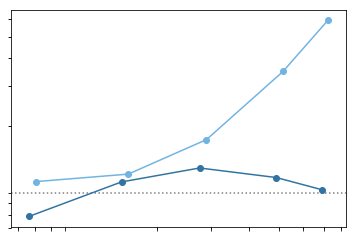

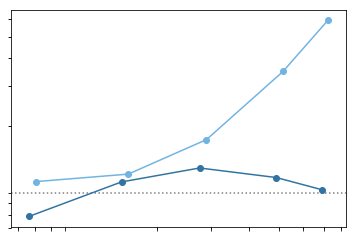

In [60]:
plot_ind(ind_df)

In [40]:
s.group_facet_plots(preds_wfac, s.fit_plot, 'plots/combined_linear_wfac_logaxes_withpred.pdf',
                  ['Task','Orientation','Presentation'], #each combo of this gets its own page
                  row='Population',col='Eye',# facet rows and columns
                  x="RelMaskContrast", y="ThreshElev", # x, y
                  hue="Subject",yerr='ThreshElev_SE',fmt_obs='o',fmt_pred='.--',Ycol="ThreshPred") 

Plotting OS.Cross.nDicho
Plotting OS.Cross.nMono
Plotting OS.Iso.nDicho
Plotting OS.Iso.nMono
Plots saved at plots/combined_linear_wfac_logaxes_withpred.pdf


### Now model only the non-facilitation points

In [ ]:
# model each group's data using functions defined in suppression.py
preds = groups.apply(s.model_condition, s.linear_nofac_err, s.linear_nofac_thresh, lm_params,
                     ret='preds', supp_only=True, log=False)

In [ ]:
preds[preds['Subject']=='bi']

In [ ]:
s.group_facet_plots(preds, s.fit_plot, 'plots/individual_linear_logaxes.pdf',
                  ['Subject','Task'], #each combo of this gets its own page
                  row='Orientation',col='Trace',# facet rows and columns
                  x="RelMaskContrast", y="ThreshElev", # x, y
                  hue="Presentation",yerr='ThreshElev_SE',fmt_obs='o',fmt_pred='.--',Ycol="ThreshElev") 

In [ ]:
s.group_facet_plots(preds, s.fit_plot, 'plots/individual_linear_logaxes_withpred.pdf',
                  ['Subject','Task'], #each combo of this gets its own page
                  row='Orientation',col='Trace',# facet rows and columns
                  x="RelMaskContrast", y="ThreshElev", # x, y
                  hue="Presentation",yerr='ThreshElev_SE',fmt_obs='o',fmt_pred='.--',Ycol="ThreshPred") 

In [ ]:
s.group_facet_plots(preds, s.fit_plot, 'plots/combined_linear_logaxes_nopred.pdf',
                  ['Task','Orientation'], #each combo of this gets its own page
                  row='Presentation',col='Trace',# facet rows and columns
                  x="RelMaskContrast", y="ThreshElev", # x, y
                  hue="Subject",yerr='ThreshElev_SE',fmt_obs='o',fmt_pred='.--',Ycol="ThreshElev") 

In [ ]:
s.group_facet_plots(preds, s.fit_plot, 'plots/combined_linear_logaxes_withpred.pdf',
                  ['Task','Orientation'], #each combo of this gets its own page
                  row='Presentation',col='Trace',# facet rows and columns
                  x="RelMaskContrast", y="ThreshElev", # x, y
                  hue="Subject",yerr='ThreshElev_SE',fmt_obs='o',fmt_pred='x--',Ycol="ThreshPred") 

### Model the data again, but this time return parameters, not predictions ###

In [41]:
# suppression only (no facilitation data points)
# model each group's data using functions defined in suppression.py, return params
#groups_with_baseline = sdf.groupby(pp_gvars_base)
#pfit = groups_with_baseline.apply(s.model_condition, s.linear_nofac_err, s.linear_nofac_thresh, lm_params, ret='weights', supp_only=True).reset_index()

In [42]:
pp_gvars_base

['Task',
 'Orientation',
 'Presentation',
 'Population',
 'Subject',
 'Eye',
 'Trace',
 'BaselineThresh']

In [43]:
# include facilitation data points
# model each group's data using functions defined in suppression.py, return params
groups_with_baseline = df_to_model.groupby(pp_gvars_base)
pfit = groups_with_baseline.apply(s.model_condition, s.linear_nofac_err, s.linear_nofac_thresh,
                                  lm_params, ret='weights', predtype='linear', 
                                  supp_only=False).reset_index()

('OS', 'Cross', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De', 2.1840000000000002) 1.803
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01333     -inf      inf  0.02213     True     None     None
y_int     0.939     -inf      inf   0.2331     True     None     None
('OS', 'Cross', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De', 2.1840000000000002) 1.803
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01333     -inf      inf  0.02213     True     None     None
y_int     0.939     -inf      inf   0.2331     True     None     None
('OS', 'Cross', 'nDicho', 'Amblyope', 'am', 'Nde', 'Amblyope-Nde', 2.6699999999999999) 3.074
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.01771     -inf      inf  0.03058     True     None     None
y_int     1.049     -inf      inf   0.3938     True     None     None
('OS', 'Cross', 'nDicho', 'Amblyope', 'bi', 'De', 'Amblyope-De', 1.6680000000000001) 1.80

('OS', 'Cross', 'nDicho', 'Control', 'jd', 'De', 'Control-De', 2.819) 8.766
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.02891     -inf      inf 0.009449     True     None     None
y_int     1.067     -inf      inf    0.122     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'jd', 'Nde', 'Control-Nde', 3.1120000000000001) 8.031
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope     0.135     -inf      inf 0.0008327     True     None     None
y_int    0.9016     -inf      inf  0.01187     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'kw', 'De', 'Control-De', 1.7969999999999999) 8.766
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1372     -inf      inf  0.01763     True     None     None
y_int     1.016     -inf      inf   0.2583     True     None     None
('OS', 'Cross', 'nDicho', 'Control', 'kw', 'Nde', 'Control-Nde', 1.9790000000000001) 8.031
Name      Value 

slope   0.02768     -inf      inf 0.006279     True     None     None
y_int     0.944     -inf      inf  0.06508     True     None     None
('OS', 'Cross', 'nMono', 'Control', 'ct', 'Nde', 'Control-Nde', 3.395) 4.932
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.02394     -inf      inf  0.01676     True     None     None
y_int    0.8895     -inf      inf   0.1686     True     None     None
('OS', 'Cross', 'nMono', 'Control', 'dl', 'De', 'Control-De', 1.5740000000000001) 4.898
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.02768     -inf      inf 0.009086     True     None     None
y_int     1.135     -inf      inf   0.2341     True     None     None
('OS', 'Cross', 'nMono', 'Control', 'dl', 'Nde', 'Control-Nde', 1.7290000000000001) 4.932
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.03575     -inf      inf 0.003782     True     None     None
y_int     0.653     -inf      inf  0.08

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope     1.038     -inf      inf   0.1554     True     None     None
y_int   -0.5153     -inf      inf   0.6409     True     None     None
('OS', 'Iso', 'nDicho', 'Amblyope', 'rn', 'Nde', 'Amblyope-Nde', 4.4809999999999999) 7.932
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.6947     -inf      inf   0.1084     True     None     None
y_int    0.3322     -inf      inf    1.152     True     None     None
('OS', 'Iso', 'nDicho', 'Amblyope', 'sd', 'De', 'Amblyope-De', 1.6369999999999998) 4.942
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope  0.005947     -inf      inf  0.01632     True     None     None
y_int     1.022     -inf      inf  0.03011     True     None     None
('OS', 'Iso', 'nDicho', 'Amblyope', 'sd', 'Nde', 'Amblyope-Nde', 7.1710000000000003) 7.932
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope      0.18     -

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.2148     -inf      inf    0.105     True     None     None
y_int   -0.3649     -inf      inf    1.338     True     None     None
('OS', 'Iso', 'nDicho', 'Control', 'yl', 'De', 'Control-De', 2.1600000000000001) 4.946
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.4673     -inf      inf   0.1002     True     None     None
y_int    -2.406     -inf      inf    1.911     True     None     None
('OS', 'Iso', 'nDicho', 'Control', 'yl', 'Nde', 'Control-Nde', 1.79) 4.91
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.8146     -inf      inf   0.1653     True     None     None
y_int    -3.735     -inf      inf    2.614     True     None     None
('OS', 'Iso', 'nMono', 'Amblyope', 'am', 'De', 'Amblyope-De', 2.1840000000000002) 21.351
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1722     -inf      inf  0.04491

('OS', 'Iso', 'nMono', 'Control', 'mk', 'De', 'Control-De', 2.7450000000000001) 4.898
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope       0.1     -inf      inf   0.1734     True     None     None
y_int      1.88     -inf      inf    1.831     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'mk', 'Nde', 'Control-Nde', 2.8460000000000001) 4.953
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope    0.1512     -inf      inf   0.1011     True     None     None
y_int     1.572     -inf      inf     1.03     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'ms', 'De', 'Control-De', 2.0409999999999999) 4.898
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
slope   0.03458     -inf      inf   0.0168     True     None     None
y_int     1.147     -inf      inf   0.3307     True     None     None
('OS', 'Iso', 'nMono', 'Control', 'ms', 'Nde', 'Control-Nde', 1.8480000000000001) 4.953
Name      Value 

In [44]:
pfit.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,ThreshPredCritical,ThreshPredCriticalUnnorm
0,OS,Cross,nDicho,Amblyope,am,De,Amblyope-De,2.184,0.939042,0.013325,0.963067,2.103339
1,OS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,2.670,1.049378,0.017715,1.103833,2.947235
2,OS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,1.668,0.910471,0.022884,0.951731,1.587488
3,OS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,2.706,5.436084,0.792939,7.873580,21.305907
4,OS,Cross,nDicho,Amblyope,gd,De,Amblyope-De,2.454,0.650107,0.067567,0.771930,1.894316


In [45]:
pp_gvars, pp_gvars_base

(['Task',
  'Orientation',
  'Presentation',
  'Population',
  'Subject',
  'Eye',
  'Trace'],
 ['Task',
  'Orientation',
  'Presentation',
  'Population',
  'Subject',
  'Eye',
  'Trace',
  'BaselineThresh'])

In [46]:
# melt the result of the modeling into long format for plotting
m = pd.melt(pfit, id_vars=pp_gvars, var_name='measure')
m.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value
0,OS,Cross,nDicho,Amblyope,am,De,Amblyope-De,BaselineThresh,2.184
1,OS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,2.670
2,OS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,1.668
3,OS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,BaselineThresh,2.706
4,OS,Cross,nDicho,Amblyope,gd,De,Amblyope-De,BaselineThresh,2.454


In [47]:
#Grab the GABA measure for each subject and it to each observation for easy plotting
comb = m.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
print(len(comb))
comb = comb[(comb['measure'] == 'BaselineThresh') | (comb['measure']=='ThreshPredCritical') | (comb['measure'] == 'ThreshPredCriticalUnnorm')]
print(len(comb))
comb.head()

900
540


,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value,GABA
0,OS,Cross,nDicho,Amblyope,am,De,Amblyope-De,BaselineThresh,2.184,0.193
1,OS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,2.670,0.193
2,OS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,1.668,0.207
3,OS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,BaselineThresh,2.706,0.207
4,OS,Cross,nDicho,Amblyope,gd,De,Amblyope-De,BaselineThresh,2.454,0.203


In [48]:
#graphs!
with s.PdfPages('plots/gaba_vs_measures_wfac_linear_measure.pdf') as pdf:
    plot_groups = comb.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv, np.all(np.isnan(gr['value'])))
        #if gv[0]=='SS' and gv[1]=='Cross': continue
        xvar = "GABA"
        x_lbl = "GABA (relative to creatine)"
        yvar = "value"
        y_lbl = {'BaselineThresh':'Baseline Threshold (C%)',
                'ThreshPredCritical':'Threshold Elevation (relative to baseline)',
                'ThreshPredCriticalUnnorm':'Predicted Threshold (C%)'}
        g = sns.lmplot(data=gr, 
                  row='Presentation',col='Population',# facet rows and columns
                  x=xvar, y=yvar,hue="Eye",sharey=False, markers=["o","x"])
        g.fig.suptitle(gv, fontsize=16, y=0.97)
        g.fig.subplots_adjust(top=.9, right=.8)
        g.set_axis_labels(x_lbl, y_lbl[gv[2]])
        pdf.savefig(g.fig)
        plt.close(g.fig)
        
        g = sns.lmplot(data=gr, 
                  row='Presentation',col='measure',# facet rows and columns
                  x=xvar, y=yvar,hue="Trace",sharey=False, markers=["o","x","s","d"])
        g.fig.suptitle(gv, fontsize=16, y=0.97)
        g.fig.subplots_adjust(top=.9, right=.8)
        g.set_axis_labels(xvar, y_lbl[gv[2]])
        pdf.savefig(g.fig)
        plt.close(g.fig)
        
    plt.close('all')

('OS', 'Cross', 'BaselineThresh') False
('OS', 'Cross', 'ThreshPredCritical') False
('OS', 'Cross', 'ThreshPredCriticalUnnorm') False
('OS', 'Iso', 'BaselineThresh') False
('OS', 'Iso', 'ThreshPredCritical') False
('OS', 'Iso', 'ThreshPredCriticalUnnorm') False


In [49]:
#graphs!
with s.PdfPages('plots/gaba_vs_measures_wfac_linear_trace.pdf') as pdf:
    plot_groups = comb.groupby(['Task','Orientation'])
    for gv, gr in plot_groups:
        print(gv, np.all(np.isnan(gr['value'])))
        xvar = "GABA"
        yvar = "value"
        x_lbl = "GABA (relative to creatine)"
        g = sns.lmplot(data=gr, 
                  row='Presentation',col='measure',# facet rows and columns
                  x=xvar, y=yvar,hue="Trace",sharey=False, markers=["o","x","s","d"])
        g.fig.suptitle(gv, fontsize=16, y=0.97)
        g.fig.subplots_adjust(top=.9, right=.8)
        g.set_axis_labels(xvar, yvar)
        pdf.savefig(g.fig)
    plt.close('all')

('OS', 'Cross') False
('OS', 'Iso') False


#### combine measures across the two eyes

In [50]:
paired_obs = comb.groupby(['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure'])

def get_eyediff_value(g):
    if len(g)==2:
        value_diff = g[g['Eye']=='Nde'].value.iat[0] - g[g['Eye']=='De'].value.iat[0]
        print(g.name, value_diff)
        return pd.Series([value_diff], ['Nde-De'])

In [51]:
obs_diff = paired_obs.apply(get_eyediff_value).reset_index()

('OS', 'Cross', 'Amblyope', 'nDicho', 'am', 'BaselineThresh') 0.486
('OS', 'Cross', 'Amblyope', 'nDicho', 'am', 'BaselineThresh') 0.486
('OS', 'Cross', 'Amblyope', 'nDicho', 'am', 'ThreshPredCritical') 0.140766211809
('OS', 'Cross', 'Amblyope', 'nDicho', 'am', 'ThreshPredCriticalUnnorm') 0.843896405413
('OS', 'Cross', 'Amblyope', 'nDicho', 'bi', 'BaselineThresh') 1.038
('OS', 'Cross', 'Amblyope', 'nDicho', 'bi', 'ThreshPredCritical') 6.92184867769
('OS', 'Cross', 'Amblyope', 'nDicho', 'bi', 'ThreshPredCriticalUnnorm') 19.7184196289
('OS', 'Cross', 'Amblyope', 'nDicho', 'gd', 'BaselineThresh') -0.01
('OS', 'Cross', 'Amblyope', 'nDicho', 'gd', 'ThreshPredCritical') 0.512307111944
('OS', 'Cross', 'Amblyope', 'nDicho', 'gd', 'ThreshPredCriticalUnnorm') 1.24435928336
('OS', 'Cross', 'Amblyope', 'nDicho', 'jv', 'BaselineThresh') 0.883
('OS', 'Cross', 'Amblyope', 'nDicho', 'jv', 'ThreshPredCritical') 1.29783499565
('OS', 'Cross', 'Amblyope', 'nDicho', 'jv', 'ThreshPredCriticalUnnorm') 3.73734

('OS', 'Iso', 'Control', 'nDicho', 'kw', 'ThreshPredCriticalUnnorm') 3.94748350709
('OS', 'Iso', 'Control', 'nDicho', 'ls', 'BaselineThresh') 0.358
('OS', 'Iso', 'Control', 'nDicho', 'ls', 'ThreshPredCritical') -1.25147405844
('OS', 'Iso', 'Control', 'nDicho', 'ls', 'ThreshPredCriticalUnnorm') -1.86064406963
('OS', 'Iso', 'Control', 'nDicho', 'mk', 'BaselineThresh') 0.101
('OS', 'Iso', 'Control', 'nDicho', 'mk', 'ThreshPredCritical') 0.514172008729
('OS', 'Iso', 'Control', 'nDicho', 'mk', 'ThreshPredCriticalUnnorm') 2.09051635111
('OS', 'Iso', 'Control', 'nDicho', 'ms', 'BaselineThresh') -0.193
('OS', 'Iso', 'Control', 'nDicho', 'ms', 'ThreshPredCritical') 2.16305045553
('OS', 'Iso', 'Control', 'nDicho', 'ms', 'ThreshPredCriticalUnnorm') 3.4565890691
('OS', 'Iso', 'Control', 'nDicho', 'nl', 'BaselineThresh') -0.586
('OS', 'Iso', 'Control', 'nDicho', 'nl', 'ThreshPredCritical') -0.188561154054
('OS', 'Iso', 'Control', 'nDicho', 'nl', 'ThreshPredCriticalUnnorm') -0.833113853297
('OS', 'I

In [52]:
obs_diff.head(n=20)

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De
0,OS,Cross,Amblyope,nDicho,am,BaselineThresh,0.486000
1,OS,Cross,Amblyope,nDicho,am,ThreshPredCritical,0.140766
2,OS,Cross,Amblyope,nDicho,am,ThreshPredCriticalUnnorm,0.843896
3,OS,Cross,Amblyope,nDicho,bi,BaselineThresh,1.038000
4,OS,Cross,Amblyope,nDicho,bi,ThreshPredCritical,6.921849
5,OS,Cross,Amblyope,nDicho,bi,ThreshPredCriticalUnnorm,19.718420
6,OS,Cross,Amblyope,nDicho,gd,BaselineThresh,-0.010000
7,OS,Cross,Amblyope,nDicho,gd,ThreshPredCritical,0.512307
8,OS,Cross,Amblyope,nDicho,gd,ThreshPredCriticalUnnorm,1.244359
9,OS,Cross,Amblyope,nDicho,jv,BaselineThresh,0.883000


In [53]:
comb_botheyes = obs_diff.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [54]:
comb_botheyes

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA
0,OS,Cross,Amblyope,nDicho,am,BaselineThresh,0.486000,0.193
1,OS,Cross,Amblyope,nDicho,am,ThreshPredCritical,0.140766,0.193
2,OS,Cross,Amblyope,nDicho,am,ThreshPredCriticalUnnorm,0.843896,0.193
3,OS,Cross,Amblyope,nDicho,bi,BaselineThresh,1.038000,0.207
4,OS,Cross,Amblyope,nDicho,bi,ThreshPredCritical,6.921849,0.207
5,OS,Cross,Amblyope,nDicho,bi,ThreshPredCriticalUnnorm,19.718420,0.207
6,OS,Cross,Amblyope,nDicho,gd,BaselineThresh,-0.010000,0.203
7,OS,Cross,Amblyope,nDicho,gd,ThreshPredCritical,0.512307,0.203
8,OS,Cross,Amblyope,nDicho,gd,ThreshPredCriticalUnnorm,1.244359,0.203
9,OS,Cross,Amblyope,nDicho,jv,BaselineThresh,0.883000,0.215


In [55]:
#graphs!
with s.PdfPages('plots/gaba_vs_measures_wfac_linear_combeyes.pdf') as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv)
        xvar = "GABA"
        yvar = "Nde-De"
        x_lbl = "GABA (relative to creatine)"
        y_lbl = {'BaselineThresh':'Baseline Threshold (C%)',
                'ThreshPredCritical':'Threshold Elevation (relative to baseline)',
                'ThreshPredCriticalUnnorm':'Predicted Threshold (C%)'}
        g = sns.lmplot(data=gr, 
                  col='Presentation',hue='Population',# facet rows and columns
                  x=xvar, y=yvar,sharey=False)
        g.fig.suptitle(gv, fontsize=16, y=0.99)
        g.fig.subplots_adjust(top=.9, right=.8)
        g.set_axis_labels(x_lbl, y_lbl[gv[2]])
        pdf.savefig(g.fig)
        plt.close(g.fig)
    plt.close('all')

('OS', 'Cross', 'BaselineThresh')
('OS', 'Cross', 'ThreshPredCritical')
('OS', 'Cross', 'ThreshPredCriticalUnnorm')
('OS', 'Iso', 'BaselineThresh')
('OS', 'Iso', 'ThreshPredCritical')
('OS', 'Iso', 'ThreshPredCriticalUnnorm')


### Load fMRI data

In [56]:
fmri_fn = 'fmri_data.txt'
fmri_df = s.load_fmri(fmri_fn)
fmri_df

,subjName,BinSumDiffV1,BinSumDiffV2d,BinSumDiffV2v,BinSumDiffV3d,BinSumDiffV3v
0,ac,0.598,0.654,0.646,0.361,0.458
1,ai,0.897,0.499,1.022,0.214,0.558
2,am,0.078,0.396,0.218,0.192,-1.156
3,as,0.011,0.148,-0.016,-0.000,-0.078
4,bi,0.129,0.406,0.290,0.112,0.104
5,ch,1.499,0.474,2.033,0.526,0.985
6,cr,0.202,0.154,0.494,0.044,0.499
7,cs,0.065,0.086,0.159,0.037,0.269
8,ct,0.275,0.434,0.353,0.332,0.321
9,dl,0.091,0.133,0.276,0.112,0.313


In [57]:
comb_botheyes = comb_botheyes.join(fmri_df.set_index(['subjName']), on=['Subject'])
comb_botheyes.head()

In [59]:
slim_df = comb_botheyes[comb_botheyes['measure']=='ThreshPredCriticalUnnorm']
final_df = pd.melt(slim_df, id_vars=['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure', 'Nde-De', 'GABA'], var_name='BinSumArea')

In [60]:
final_df

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA,BinSumArea,value
0,OS,Cross,Amblyope,nDicho,am,ThreshPredCriticalUnnorm,0.843896,0.193,BinSumDiffV1,0.078
1,OS,Cross,Amblyope,nDicho,bi,ThreshPredCriticalUnnorm,19.718420,0.207,BinSumDiffV1,0.129
2,OS,Cross,Amblyope,nDicho,gd,ThreshPredCriticalUnnorm,1.244359,0.203,BinSumDiffV1,-0.277
3,OS,Cross,Amblyope,nDicho,jv,ThreshPredCriticalUnnorm,3.737345,0.215,BinSumDiffV1,0.342
4,OS,Cross,Amblyope,nDicho,li,ThreshPredCriticalUnnorm,20.660788,0.227,BinSumDiffV1,-0.024
5,OS,Cross,Amblyope,nDicho,mg,ThreshPredCriticalUnnorm,2.666462,0.210,BinSumDiffV1,0.162
6,OS,Cross,Amblyope,nDicho,rn,ThreshPredCriticalUnnorm,4.684740,0.202,BinSumDiffV1,0.900
7,OS,Cross,Amblyope,nDicho,sd,ThreshPredCriticalUnnorm,13.761601,0.190,BinSumDiffV1,0.620
8,OS,Cross,Amblyope,nDicho,tt,ThreshPredCriticalUnnorm,1.809793,0.179,BinSumDiffV1,0.069
9,OS,Cross,Amblyope,nMono,am,ThreshPredCriticalUnnorm,0.624304,0.193,BinSumDiffV1,0.078


In [61]:
np.unique(final_df.Subject)

array(['ai', 'am', 'bi', 'cr', 'ct', 'dl', 'ei', 'es', 'gd', 'gm', 'jd',
       'jv', 'kw', 'li', 'ls', 'mg', 'mk', 'ms', 'nl', 'rn', 'sd', 'tt',
       'yl'], dtype=object)

In [70]:
r_groups_pop = final_df.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'BinSumArea'])
for rgv, rgr in r_groups_pop:
    print(rgv)
    print('Mean BinSumDiff: ', np.mean(rgr.value))
    r_gaba_fmri = (rgr.corr()['GABA']['value'])
    r_gaba_thresh = (rgr.corr()['GABA']['Nde-De'])
    print('GABA and fMRI:', r_gaba_fmri, r_gaba_fmri**2)
    print('GABA and Nde-De:', r_gaba_thresh, r_gaba_thresh**2)

('OS', 'Cross', 'nDicho', 'Amblyope', 'BinSumDiffV1')
Mean BinSumDiff:  0.22211111111111112
GABA and fMRI: -0.148589918596 0.0220789639083
GABA and Nde-De: 0.444582230924 0.197653360054
('OS', 'Cross', 'nDicho', 'Amblyope', 'BinSumDiffV2d')
Mean BinSumDiff:  0.38122222222222224
GABA and fMRI: -0.0917134754934 0.00841136158707
GABA and Nde-De: 0.444582230924 0.197653360054
('OS', 'Cross', 'nDicho', 'Amblyope', 'BinSumDiffV2v')
Mean BinSumDiff:  0.22244444444444447
GABA and fMRI: 0.0984634406878 0.00969504915208
GABA and Nde-De: 0.444582230924 0.197653360054
('OS', 'Cross', 'nDicho', 'Amblyope', 'BinSumDiffV3d')
Mean BinSumDiff:  0.15414285714285714
GABA and fMRI: -0.492541910101 0.242597533206
GABA and Nde-De: 0.444582230924 0.197653360054
('OS', 'Cross', 'nDicho', 'Amblyope', 'BinSumDiffV3v')
Mean BinSumDiff:  0.07011111111111111
GABA and fMRI: 0.358980819119 0.128867228496
GABA and Nde-De: 0.444582230924 0.197653360054
('OS', 'Cross', 'nDicho', 'Control', 'BinSumDiffV1')
Mean BinSumDi

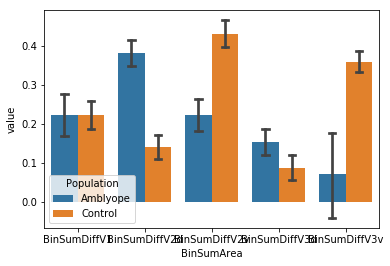

In [71]:
    ax = sns.barplot(x='BinSumArea', y='value', hue='Population', ci=68, capsize=.1, data=final_df)


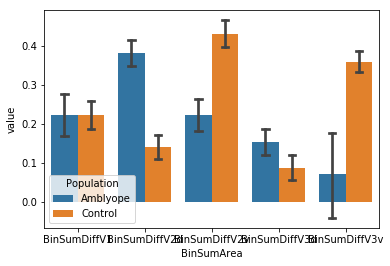

In [72]:
ax.figure

In [73]:
with s.PdfPages('plots/fmri_binsum_diffs.pdf') as pdf:
    ax = sns.barplot(x='BinSumArea', y='value', hue='Population', ci=68, capsize=.1, data=final_df)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

In [74]:
gaba_group_df = final_df[(final_df['Orientation']=='Iso') & (final_df['BinSumArea']=='BinSumDiffV1') & (final_df['Presentation']=='nDicho')]

In [75]:
st.ttest_ind(gaba_group_df[gaba_group_df['Population']=='Amblyope']['GABA'].values,gaba_group_df[gaba_group_df['Population']=='Control']['GABA'].values)

Ttest_indResult(statistic=-0.31829417599087889, pvalue=0.75340558898575316)

In [76]:
with s.PdfPages('plots/gaba_diffs.pdf') as pdf:
    ax = sns.violinplot(y='GABA',x='Task',hue='Population',data=gaba_group_df,inner='stick',split=True,aspect=1)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')
#ax = sns.swarmplot(x='Population',y='GABA',hue='Population',data=gaba_group_df,ax=ax)

In [77]:
r_groups_pop['value'].sem()

Task  Orientation  Presentation  Population  BinSumArea   
OS    Cross        nDicho        Amblyope    BinSumDiffV1     0.117757
                                             BinSumDiffV2d    0.068118
                                             BinSumDiffV2v    0.086704
                                             BinSumDiffV3d    0.072187
                                             BinSumDiffV3v    0.217060
                                 Control     BinSumDiffV1     0.079802
                                             BinSumDiffV2d    0.072597
                                             BinSumDiffV2v    0.070898
                                             BinSumDiffV3d    0.071074
                                             BinSumDiffV3v    0.060004
                   nMono         Amblyope    BinSumDiffV1     0.117757
                                             BinSumDiffV2d    0.068118
                                             BinSumDiffV2v    0.086704
                  

In [84]:
pop_means = r_groups_pop.mean().reset_index()

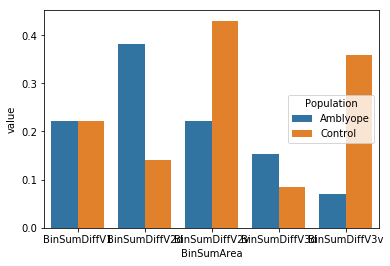

In [85]:
sns.barplot(x='BinSumArea', y='value', hue='Population', data=pop_means, ci=95)

In [86]:
r_groups_both = final_df.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'BinSumArea'])

In [87]:
for rgv, rgr in r_groups_both:
    print(rgv)
    r_gaba_fmri = (rgr.corr()['GABA']['value'])
    r_gaba_thresh = (rgr.corr()['GABA']['Nde-De'])
    print('GABA and fMRI:', r_gaba_fmri, r_gaba_fmri**2)
    print('GABA and Nde-De:', r_gaba_thresh, r_gaba_thresh**2)
    #print(np.corrcoef(rgr['GABA'], rgr['value']))

('OS', 'Cross', 'nDicho', 'Amblyope', 'BinSumDiffV1')
GABA and fMRI: -0.148589918596 0.0220789639083
GABA and Nde-De: 0.444582230924 0.197653360054
('OS', 'Cross', 'nDicho', 'Amblyope', 'BinSumDiffV2d')
GABA and fMRI: -0.0917134754934 0.00841136158707
GABA and Nde-De: 0.444582230924 0.197653360054
('OS', 'Cross', 'nDicho', 'Amblyope', 'BinSumDiffV2v')
GABA and fMRI: 0.0984634406878 0.00969504915208
GABA and Nde-De: 0.444582230924 0.197653360054
('OS', 'Cross', 'nDicho', 'Amblyope', 'BinSumDiffV3d')
GABA and fMRI: -0.492541910101 0.242597533206
GABA and Nde-De: 0.444582230924 0.197653360054
('OS', 'Cross', 'nDicho', 'Amblyope', 'BinSumDiffV3v')
GABA and fMRI: 0.358980819119 0.128867228496
GABA and Nde-De: 0.444582230924 0.197653360054
('OS', 'Cross', 'nDicho', 'Control', 'BinSumDiffV1')
GABA and fMRI: 0.548136864024 0.300454021702
GABA and Nde-De: 0.313299222137 0.0981564025919
('OS', 'Cross', 'nDicho', 'Control', 'BinSumDiffV2d')
GABA and fMRI: -0.0221762306571 0.000491785206158
GABA a

In [88]:
#graphs!

with s.PdfPages('plots/gaba_vs_fmri_joint.pdf') as pdf:
    plot_groups = final_df.groupby(['Task','Orientation'])
    for gv, gr in plot_groups:
        print(gv)
        xvar = "GABA"
        yvar = "value"
        x_lbl = "GABA (relative to creatine)"
        y_lbl = {'(Binocular - Dichoptic) BOLD amplitude (% signal)'}
        g = sns.lmplot(data=gr, row='BinSumArea',
                  col='Presentation',hue='Population',# facet rows and columns
                  x=xvar, y=yvar,sharey=False)
        g.fig.suptitle(gv, fontsize=16, y=0.99)
        g.fig.subplots_adjust(top=.9, right=.8)
        g.set_axis_labels(x_lbl, y_lbl)
        pdf.savefig(g.fig)
        plt.close(g.fig)
    plt.close('all')

('OS', 'Cross')
('OS', 'Iso')


In [89]:
final_df.head()

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA,BinSumArea,value
0,OS,Cross,Amblyope,nDicho,am,ThreshPredCriticalUnnorm,0.843896,0.193,BinSumDiffV1,0.078
1,OS,Cross,Amblyope,nDicho,bi,ThreshPredCriticalUnnorm,19.718420,0.207,BinSumDiffV1,0.129
2,OS,Cross,Amblyope,nDicho,gd,ThreshPredCriticalUnnorm,1.244359,0.203,BinSumDiffV1,-0.277
3,OS,Cross,Amblyope,nDicho,jv,ThreshPredCriticalUnnorm,3.737345,0.215,BinSumDiffV1,0.342
4,OS,Cross,Amblyope,nDicho,li,ThreshPredCriticalUnnorm,20.660788,0.227,BinSumDiffV1,-0.024


In [90]:
#graphs!

with s.PdfPages('plots/supp_vs_fmri.pdf') as pdf:
    plot_groups = final_df.groupby(['Task','Orientation'])
    for gv, gr in plot_groups:
        print(gv)
        xvar = "value"
        yvar = "Nde-De"
        x_lbl = "predicted Threshold Diff (C%, NDE-DE)"
        y_lbl = {'(Binocular - Dichoptic) BOLD amplitude (% signal)'}
        g = sns.lmplot(data=gr, row='BinSumArea',
                  col='Presentation',hue='Population',# facet rows and columns
                  x=xvar, y=yvar,sharey=False)
        g.fig.suptitle(gv, fontsize=16, y=0.99)
        g.fig.subplots_adjust(top=.9, right=.8)
        g.set_axis_labels(x_lbl, y_lbl)
        pdf.savefig(g.fig)
        plt.close(g.fig)
    plt.close('all')

('OS', 'Cross')
('OS', 'Iso')


## Model the data again, this time log-transforming the ThreshElev (and not ignoring the facilitation data points)

In [ ]:
# initialize parameters
lm_params = s.lf.Parameters()
lm_params.add('y_int', value=1)
lm_params.add('slope', value=1)
lm_params.keys()

In [ ]:
# model each group's data using functions defined in suppression.py
preds_log = groups.apply(s.model_condition, s.linear_nofac_err, s.linear_nofac_thresh, lm_params,
                     ret='preds', supp_only=False, log=True)

In [ ]:
preds_log.head(n=150)

In [ ]:
preds_log[(preds_log.Task=="SS") & (preds_log.Orientation=="Cross")]

In [ ]:
s.group_facet_plots(preds_log, s.fit_plot, 'plots/combined_loglinear_logaxes_withpred.pdf',
                  ['Task','Orientation'], #each combo of this gets its own page
                  row='Presentation',col='Trace',# facet rows and columns
                  x="RelMaskContrast", y="logThreshElev", # x, y
                  hue="Subject",yerr='ThreshElev_SE',fmt_obs='o',fmt_pred='.--',Ycol="ThreshPred") 

In [ ]:
# model each group's data using functions defined in suppression.py, return params
pfit_log = groups_with_baseline.apply(s.model_condition, s.linear_nofac_err, s.linear_nofac_thresh, lm_params, ret='weights', supp_only=False, log=True).reset_index()

In [ ]:
pfit_log

In [ ]:
# melt the result of the modeling into long format for plotting
m = pd.melt(pfit_log, id_vars=pp_gvars,var_name='measure')
m

In [ ]:
#Grab the GABA measure for each subject and it to each observation for easy plotting

comb = m.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [ ]:
#graphs!
with s.PdfPages('plots/gaba_vs_measures_loglinear.pdf') as pdf:
    plot_groups = comb.groupby(['Task','Orientation','Eye'])
    for gv, gr in plot_groups:
        print(gv, np.all(np.isnan(gr['value'])))
        if gv[0]=='SS' and gv[1]=='Cross' and gv[2]=='De': continue
        xvar = "GABA"
        yvar = "value"
        g = sns.lmplot(data=gr, 
                  row='Presentation',col='measure',# facet rows and columns
                  x=xvar, y=yvar,hue="Population",sharey=False,ci=False)
        g.fig.suptitle(gv, fontsize=16, y=0.97)
        g.fig.subplots_adjust(top=.9, right=.8)
        g.set_axis_labels(xvar, yvar)
        pdf.savefig(g.fig)
    plt.close('all')